# Project EDA Notebook

### Project by Klaas van Kempen, Shihong Zhou, Yifan Hu, and Katherine Nunez

## Overview of the Project

This project will use the given Reddit data to explore how Reddit users view, react to, and analyze collegiate basketball. We will compare sentiments and use external datasets such as team records and injuries to better understand how Reddit users react to their team successes or failures. 

This project will center around three different areas of analysis: exploratory data analysis, natural language processing (NLP), and machine learning. We expect these three different areas of analysis to display different areas of the dataset and allow us to answer a variety of questions about this data. 

We will use the Reddit data to explore the differences in sentiment between collegiate basketball fans and how the fans of the top teams from 2021-2022 reacted over the course of the season. We chose to limit our data to 2021-2022 because we wanted to ensure that our data captured an entire basketball season. The collegiate season ranges from November to about March, so by taking our data from October 2021 to April 2022, we are able to ensure that we can capture the data from an entire basketball season.


### Overview of Colleagiate Basketball

Although professional and collegiate basketball are very related, there are some key differences that we want to establish before engaging in any exploratory data analysis. We expect these differences to become apparent in some of our sentiment analysis, NLP, and even in the exploratory phase of this project.


**Collegiate Basketball:** Collegiate basketball in the United States is regulated primarily by the National Collegiate Athletic Association (NCAA). For the purposes of this project, we will be focusing on NCAA division 1 (D1) college basketball. College basketball is sorted into conferences (which typically align across sports for schools), which determines most of each team's scheduled opponents and the conference championship tournament. At the end of each season, there is a gigantic tournament to determine the college basketball champion, colloquially called March Madness. In March, 64 teams (plus four other teams who play a "play-in game") compete in a single-elimination tournament to determine the champion for the season. These players are considered amateurs, i.e. they do not receive contracts, but each collegiate basketball player is eligible to receive sponsorships and advertisement revenues.

Part of our analysis will by analyzing the r/CBB (college basketball) subreddit, but we will also be analyzing the r/jayhawks and r/UNC, the two teams to make the finals for college basketball in 2022 (Kansas won!). This way, we can also track the sentiments of the fans of the two most successful college basketball teams across the course of the season on their championship runs.



## Business Goals: Questions To Answer

Over the course of this project, we aim to answer different data science questions. The first few questions will be exploratory data analysis, which we have presented for you here. The next questions will be on NLP and machine learning, which will vary in complexity and in which part of the data set they are analyzing. We aim to answer these questions through multiple visual avenues, including plots, graphs, and charts, and aim to expose some interesting trends in professional and collegiate basketball over the course of the 2022 season.

### Exploratory Data Analysis Questions

**Business Goal 1:** Determine which college basketball games had the most reddit engagement. \
**Technical Proposal:** Use word counts in comments and number of comments to determine which game had the most fan engagement online. Identify trends in when major games occur and if there are any similarities in which teams compete in these games. Possibly correlate these major games to most successful teams by record and ranking.

**Business Goal 2:** Determine how reddit activity ebbs and flows over the course of a collegiate basketball season. Construct visuals to aid in understanding how much reddit users post over the course of the 2022 season. \
**Technical Proposal:** Use exploratory data analysis techniques to achieve some of the same outcomes as the goal above, only with collegiate subreddit data. Create opportunity to identify differences in the trends between professional and collegiate sports through word counts and post counts over the course of the season. Identify any differences between the overall CBB subreddit activity and the subreddits of the individual teams we have chosen.

**Business Goal 3:** Explore how the subreddit page of the NCAA champion in 2022, the Kansas Jayhawks, varied over the course of the season. Identify any trends in post frequency or comment length that may correlate to on-the-court successes or failures. \
**Technical Proposal:** Use trend analysis and count number of comments and comment lengths to determine excitement over the course of the NBA season. Correlate any major trends to outside data sets, including Jayhawks wins and losses or injuries of key players. Analyze any additional trends in activity over the course of the 2022 season to find any other additional results before entering into the NLP phase of the project.

**Business Goal 4:** Identify the teams that have the most engagement on the main college basketball subreddit.
**Technical Proposal:** Use grouping and sorting algorithms to find which college basketball teams are the most mentioned teams. Identify if these mentions ebb or flow over the course of the season. Incorporate external datasets such as basketball rankings to correlate mentions with popular games or teams.

### Natural Language Processing (NLP) Questions

**Business Goal 5:** Rank CBB players in terms of popularity across subreddits. Determine if the popularity is "positive" or "negative". \
**Technical Proposal:** Use NLP techniques to identify which players are the most popular in collegiate basketball by analyzing how many times they are mentioned or are referred to in comments. Extract mentions of player names using NLP techniques and count frequency. Combine with sentiment scores to create a popularity index. Use sentiment analysis techniques to determine if this popularity is due to positive or negative sentiment. Compare trends in these players' appearance in comments to external factors, such as on-the-court statistics or injuries.

**Business Goal 6:** Understand how player transfers in CBB affect fan engagement on relevant subreddits. \
**Technical Proposal:** Conduct time-series analysis of post and comment frequencies before and after trade announcements. Apply statistical tests to determine significance. Use sentiment analysis to determine how fans feel about each trade. Integrate external data sets to see if fan sentiment agrees with conventional wisdom on the success of trades.

**Business Goal 7:** Determine how collegiate fan bases react after big wins and big losses. Identify volatility over the course of the season, especially for teams we know reach the championship. \
**Technical Proposal:** Identify fan sentiment for two days following a "big win" or a "big loss". A big win could be some definition such as by beating a team by 20 points, and a big loss could be some definition such as losing to a team by more than 20 points. Analyze how fans of championship-caliber teams react to victory and defeat. Use NLP techniques to identify any rivalries or particularly important games to fanbases.

**Business Goal 8:** Determine if sentiment correlates to team success on CBB subreddits. Identify fan sentiment over the course of a championship-caliber season. \
**Technical Proposal:** Use NLP techniques to conduct trend analysis on sentiment across individual subreddits for CBB teams. Identify how positive and negative sentiment fluxuate over the course of a season. Use NLP to identify additional trends around March and June, the time of the playoffs, and how fan sentiment changes (or does not change) during the postseason.

**Business Goal 9:** Determine which teams are the most liked or most hated in college basketball. \
**Technical Proposal:** Incorporate results of the EDA portion of most mentioned teams. Conduct NLP analysis to determine if these mentions are positive or negative. Expand analysis to surrounding comments and threads to understand which teams are generally viewed favorably or which are viewed negatively. Use external news sources to understand how fans view unlikely winners, such as "cinderella stories," or losers, such as "upsets."


### Machine Learning Questions

**Business Goal 9:** Assess if the sentiment on CBB subreddits can help predict game outcomes. \
**Technical Proposal:** Build a machine learning model using historical game outcomes and pre-game subreddit sentiment as features. Use external data sets, such as season win/loss records, to create predictive model that incorporates pre-game sentiment. Test data on 2022-2023 season to determine accuracy of said model.

**Business Goal 10:** Determine what do subreddits look like in the lead up to big games or big tournaments. \
**Technical Proposal:** Start with postseason sentiment analysis, then use cluster modeling or some similar machine learning technique to identify important games throughout the course of the season. Correlate these important games to external factors, such as rivalries, injuries, or trades. Visualize results by grouping important games over the course of the regular season and post season.

**Business Goal 11:** Assess if the Kansas Jayhawks or UNC Tar Heel subreddits more volatile throughout the season. \
**Technical Proposal:** Compare NBA and CBB subreddits using a multitude of machine learning techniques to identify which have more varied reactions, posting tempos, or other factors. Identify which have a wider variety of types of post and poster over the course of a season. Determine if NBA fans or CBB fans are more volatile in their reaction timing, tempo, length, and frequency over the course of a season.

**Business Goal 12:** Predict which college basketball players will become major NBA stars based on Reddit discussions. \
**Technical Proposal:** Monitor mentions and sentiments around CBB players. Track those who enter the NBA and evaluate their performance using regression analysis against Reddit metrics. Use draft status and 2022-2023 NBA season statistics to verify these outcomes.




### An Aside

We initially conceptualized this project as a comparison of professional and collegiate basketball. When we began our initial data pulls of the reddit data, we found that this data would be too big and too unweildy to complete a project like this one. Below is our overview of professional basketball and our initial proposal.

**Professional Basketball:** Professional basketball in the United States is played in the National Basketball Association (NBA). The NBA has feeder leagues (such as the G League), and there are other international leagues as well. The NBA consists of 30 teams, most if not all of which have their own subreddits. Each NBA team has 15 players, in addition to two two-way contracts between the NBA and the G League. Each player in the NBA is paid via contract, and each are eligible for any advertising or sponsorship money that they pursue in addition to their contractual responsibilities. 

Part of our analysis would've been analyzing the r/NBA subreddit and also the r/bostonceltics and r/warriors subreddits, as those were the two teams to make the NBA finals in 2022 (the Golden State Warriors were the 2022 NBA champions). This way, we would've been able to track the sentiments of the two most successful teams in the NBA across the season.

### Setting up Pyspark

### Reading in Reddit Data

### Selecting Desired Subreddits

In [ ]:
from pyspark.sql.functions import *
from datetime import datetime

start_timestamp = datetime(2021, 11, 1)
end_timestamp = datetime(2022, 4, 5)

submissions = submissions.filter((col("created_utc") >= start_timestamp) & (col("created_utc") <= end_timestamp))
comments = comments.filter((col("created_utc") >= start_timestamp) & (col("created_utc") <= end_timestamp))

In [ ]:
# start with small data (remove this when we scale up)
submissions_small = submissions.sample(0.0001)

### EDA

#### Basic Data Summary

In [ ]:
print("Total Submissions")
submissions.count()
print("Total Comments")
comments.count()

print("Count")
submissions.groupBy('subreddit').count().show()
comments.groupBy('subreddit').count().show()

In [ ]:
q = (
    submissions_small
    .withColumn("day", dayofmonth(col("created_utc")))
    .withColumn("month", month(col("created_utc")))
    .withColumn("year", year(col("created_utc")))
    .groupBy("year", "month", "day")
    .count()
)
q.show()
df = q.toPandas()

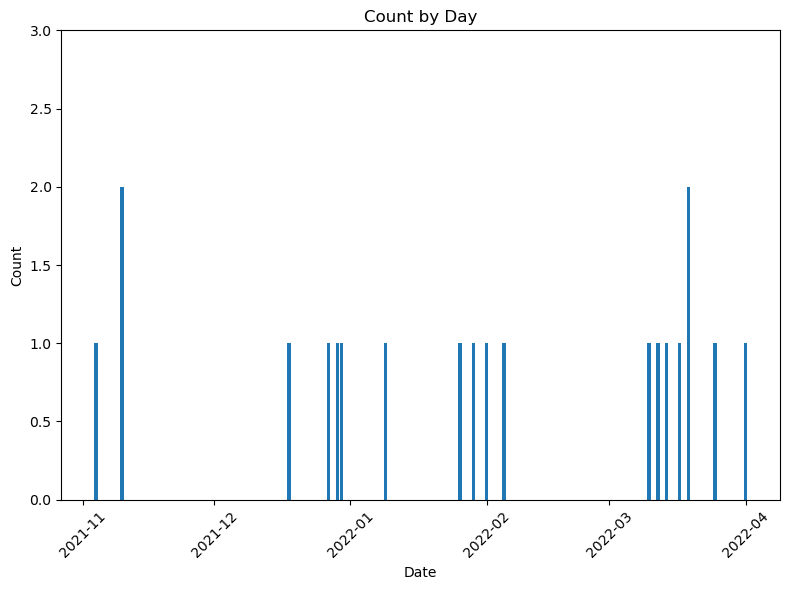

In [22]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
plt.figure(figsize=(8, 6))
plt.bar(df['date'], df['count'])
plt.xlabel('Date')
plt.ylabel('Count')
plt.ylim(0,3)
plt.title('Count by Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## EDA